# Particle Identification Notebook

We tackle the particle identification of neutrons and gamma-rays using LaBr3 detectors (gamma rays) and CLYC detecotrs (neutrons). It is critical to correctly identify the particles in order to perform the coincidence analysis. 

## Imports

In [1]:
import numpy             as np
import pandas            as pd
import matplotlib.pyplot as plt

from DataFormat  import DataFormat
from read_data   import read_data
from calibration import read_calibration_parameters, linear_calibration

from sklearn.cluster import DBSCAN, OPTICS, KMeans, MiniBatchKMeans
from matplotlib.colors import LogNorm

from sklearn.preprocessing import StandardScaler

import seaborn as sns
import tensorflow as tf

## Constants

In [2]:
DATA_PATH   = "./data"
DATA_PREFIX = "beam-analysis-day"

LABR_A  = "labr-a"
LABR_B  = "labr-b"
CLYC    = "clyc"
PLASTIC = "plastic"

## Read data

In [3]:
run_day  = 3

data_labr_a = read_data(DATA_PATH, f"{DATA_PREFIX}{run_day}.root", DataFormat(LABR_A))
data_labr_b = read_data(DATA_PATH, f"{DATA_PREFIX}{run_day}.root", DataFormat(LABR_A))
data_clyc   = read_data(DATA_PATH, f"{DATA_PREFIX}{run_day}.root", DataFormat(CLYC))

In [4]:
# clean data from saturated events
data_labr_a = data_labr_a[data_labr_a["energy"] < data_labr_a["energy"].max()]
data_labr_b = data_labr_b[data_labr_b["energy"] < data_labr_b["energy"].max()]
data_clyc   = data_clyc[data_clyc["energy"] < data_clyc["energy"].max()]

# clean data from zero energy events
data_labr_a = data_labr_a[data_labr_a["energy"] > 0]
data_labr_b = data_labr_b[data_labr_b["energy"] > 0]
data_clyc   = data_clyc[data_clyc["energy"] > 0]

## Calibration

In [5]:
param_labr_a = read_calibration_parameters(
    "./calibration-parameters/labr_a_linear_parameters.txt"
)

param_labr_b = read_calibration_parameters(
    "./calibration-parameters/labr_b_linear_parameters.txt"
)

param_clyc = read_calibration_parameters(
    "./calibration-parameters/clyc_linear_parameters.txt"
)

In [6]:
data_labr_a.loc[:, "energy_calib"]       = linear_calibration(data_labr_a["energy"], param_labr_a)
data_labr_a.loc[:, "energy_short_calib"] = linear_calibration(data_labr_a["energy_short"], param_labr_a)

data_labr_b.loc[:, "energy_calib"]       = linear_calibration(data_labr_b["energy"], param_labr_b)
data_labr_b.loc[:, "energy_short_calib"] = linear_calibration(data_labr_b["energy_short"], param_labr_b)

data_clyc.loc[:,   "energy_calib"]       = linear_calibration(data_clyc["energy"], param_clyc)
data_clyc.loc[:,   "energy_short_calib"] = linear_calibration(data_clyc["energy_short"], param_clyc)

In [7]:
def compute_psd(df):
    return (df["energy"] - df["energy_short"]) / df["energy"]

def compute_psd_calib(df):
    return (df["energy_calib"] - df["energy_short_calib"]) / df["energy_calib"]

data_labr_a.loc[:, "psd"] = compute_psd(data_labr_a)
data_labr_b.loc[:, "psd"] = compute_psd(data_labr_b)
data_clyc.loc[:,   "psd"] = compute_psd(data_clyc)
data_labr_a.loc[:, "psd_calib"] = compute_psd_calib(data_labr_a)
data_labr_b.loc[:, "psd_calib"] = compute_psd_calib(data_labr_b)
data_clyc.loc[:,   "psd_calib"] = compute_psd_calib(data_clyc)

In [8]:
# remove all points that have a psd or psd_calib value greater than 1
def remove_psd_outliers(df):
    return df[(df["psd"] < 1) & (df["psd_calib"] < 1)]

data_labr_a = remove_psd_outliers(data_labr_a)
data_labr_b = remove_psd_outliers(data_labr_b)
data_clyc   = remove_psd_outliers(data_clyc)

## Spectra and PSD

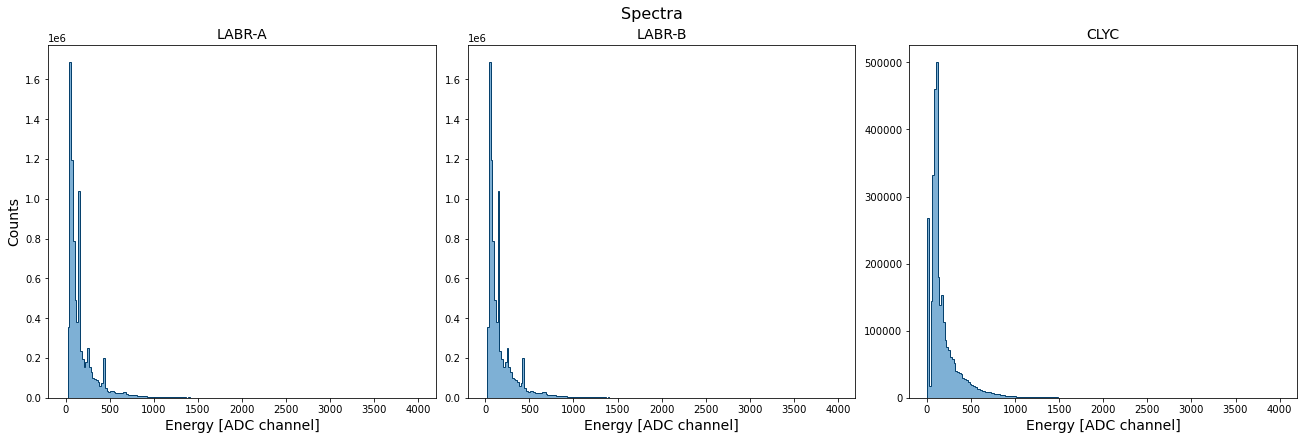

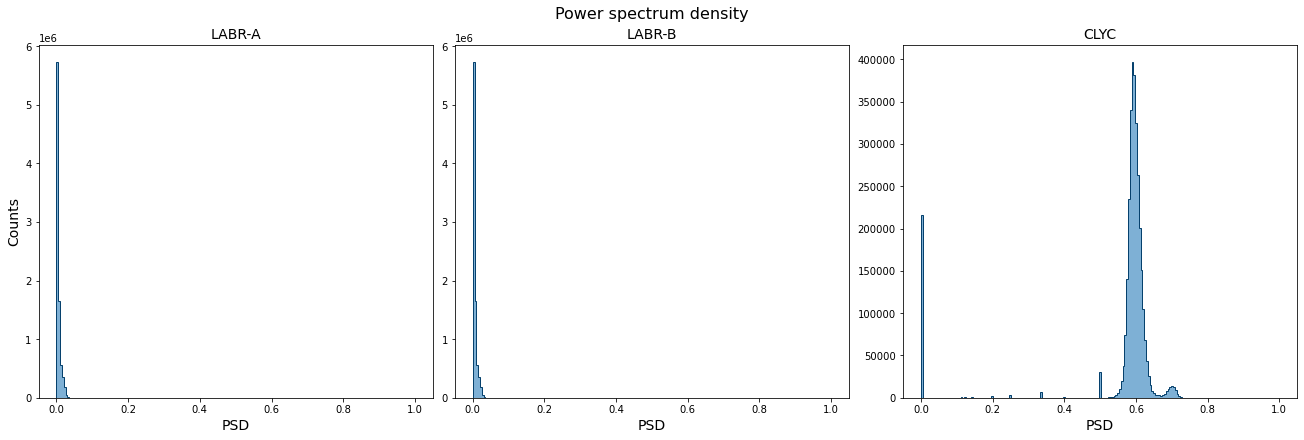

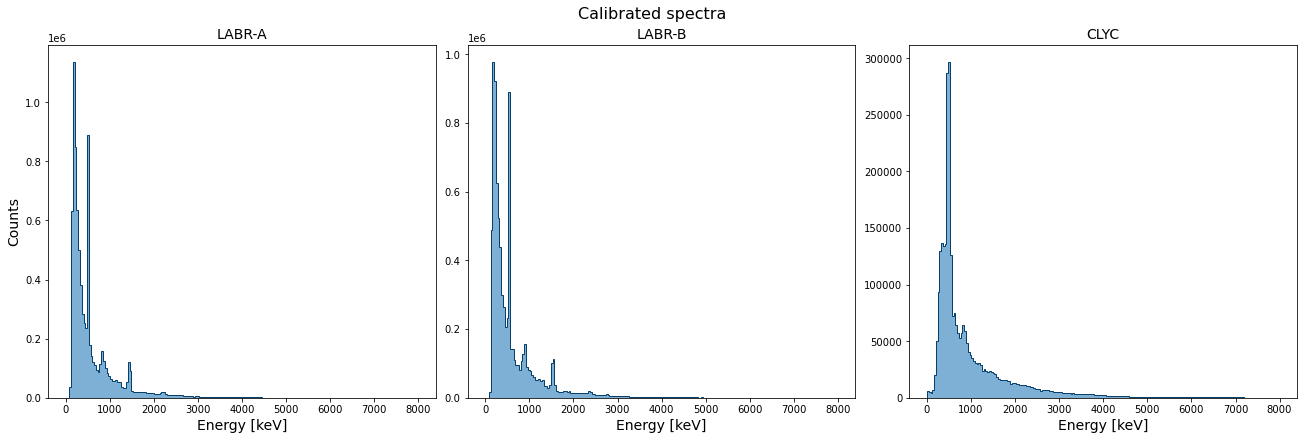

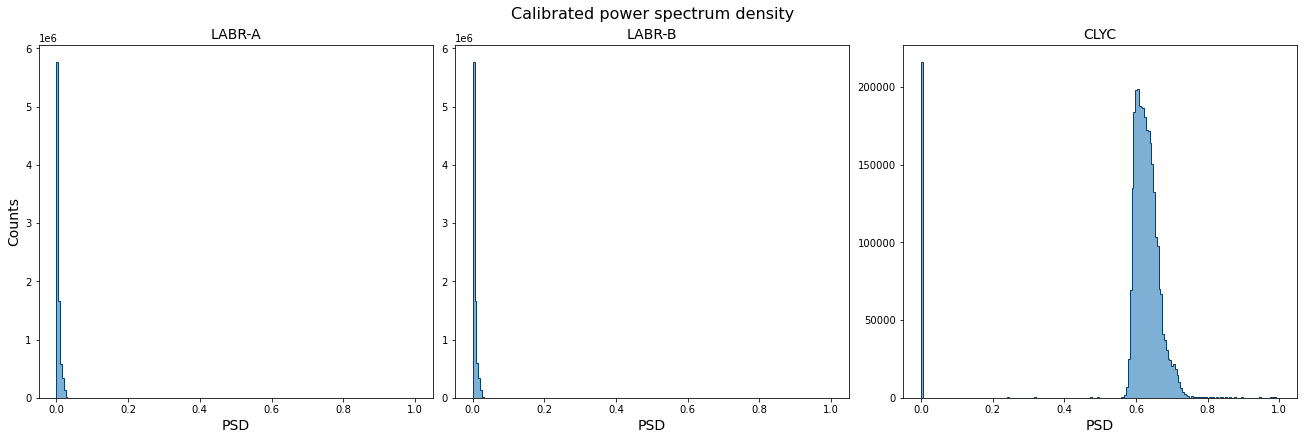

In [9]:
fig, ax = plt.subplots(1, 3, figsize=(18, 6), constrained_layout=True, sharex=True)

bins = np.linspace(0, 4000, 200)

ax[0].hist(data_labr_a["energy"], bins=bins, histtype="stepfilled", edgecolor = "#06416D", facecolor = "#7eb0d5", label="LABR-A")
ax[1].hist(data_labr_b["energy"], bins=bins, histtype="stepfilled", edgecolor = "#06416D", facecolor = "#7eb0d5", label="LABR-B")
ax[2].hist(data_clyc["energy"],   bins=bins, histtype="stepfilled", edgecolor = "#06416D", facecolor = "#7eb0d5", label="CLYC")

fig.suptitle("Spectra", fontsize=16)
ax[0].set_title("LABR-A", fontsize=14)
ax[0].set_ylabel("Counts", fontsize=14)
ax[0].set_xlabel("Energy [ADC channel]", fontsize=14)
ax[1].set_title("LABR-B", fontsize=14)
ax[1].set_xlabel("Energy [ADC channel]", fontsize=14)
ax[2].set_title("CLYC", fontsize=14)
ax[2].set_xlabel("Energy [ADC channel]", fontsize=14)

plt.show()

fig, ax = plt.subplots(1, 3, figsize=(18, 6), constrained_layout=True, sharex=True)

bins = np.linspace(0, 1, 200)

ax[0].hist(data_labr_a["psd"], bins=bins, histtype="stepfilled", edgecolor = "#06416D", facecolor = "#7eb0d5", label="LABR-A")
ax[1].hist(data_labr_b["psd"], bins=bins, histtype="stepfilled", edgecolor = "#06416D", facecolor = "#7eb0d5", label="LABR-B")
ax[2].hist(data_clyc["psd"],   bins=bins, histtype="stepfilled", edgecolor = "#06416D", facecolor = "#7eb0d5", label="CLYC")

fig.suptitle("Power spectrum density", fontsize=16)
ax[0].set_title("LABR-A", fontsize=14)
ax[0].set_ylabel("Counts", fontsize=14)
ax[0].set_xlabel("PSD", fontsize=14)
ax[1].set_title("LABR-B", fontsize=14)
ax[1].set_xlabel("PSD", fontsize=14)
ax[2].set_title("CLYC", fontsize=14)
ax[2].set_xlabel("PSD", fontsize=14)

plt.show()


fig, ax = plt.subplots(1, 3, figsize=(18, 6), constrained_layout=True, sharex=True)

bins = np.linspace(0, 8000, 200)

ax[0].hist(data_labr_a["energy_calib"], bins=bins, histtype="stepfilled", edgecolor = "#06416D", facecolor = "#7eb0d5", label="LABR-A")
ax[1].hist(data_labr_b["energy_calib"], bins=bins, histtype="stepfilled", edgecolor = "#06416D", facecolor = "#7eb0d5", label="LABR-B")
ax[2].hist(data_clyc["energy_calib"],   bins=bins, histtype="stepfilled", edgecolor = "#06416D", facecolor = "#7eb0d5", label="CLYC")

fig.suptitle("Calibrated spectra", fontsize=16)
ax[0].set_title("LABR-A", fontsize=14)
ax[0].set_ylabel("Counts", fontsize=14)
ax[0].set_xlabel("Energy [keV]", fontsize=14)
ax[1].set_title("LABR-B", fontsize=14)
ax[1].set_xlabel("Energy [keV]", fontsize=14)
ax[2].set_title("CLYC", fontsize=14)
ax[2].set_xlabel("Energy [keV]", fontsize=14)

plt.show()

fig, ax = plt.subplots(1, 3, figsize=(18, 6), constrained_layout=True, sharex=True)

bins = np.linspace(0, 1, 200)

ax[0].hist(data_labr_a["psd_calib"], bins=bins, histtype="stepfilled", edgecolor = "#06416D", facecolor = "#7eb0d5", label="LABR-A")
ax[1].hist(data_labr_b["psd_calib"], bins=bins, histtype="stepfilled", edgecolor = "#06416D", facecolor = "#7eb0d5", label="LABR-B")
ax[2].hist(data_clyc["psd_calib"],   bins=bins, histtype="stepfilled", edgecolor = "#06416D", facecolor = "#7eb0d5", label="CLYC")

fig.suptitle("Calibrated power spectrum density", fontsize=16)
ax[0].set_title("LABR-A", fontsize=14)
ax[0].set_ylabel("Counts", fontsize=14)
ax[0].set_xlabel("PSD", fontsize=14)
ax[1].set_title("LABR-B", fontsize=14)
ax[1].set_xlabel("PSD", fontsize=14)
ax[2].set_title("CLYC", fontsize=14)
ax[2].set_xlabel("PSD", fontsize=14)

plt.show()

## PSD vs Energy for CLYC

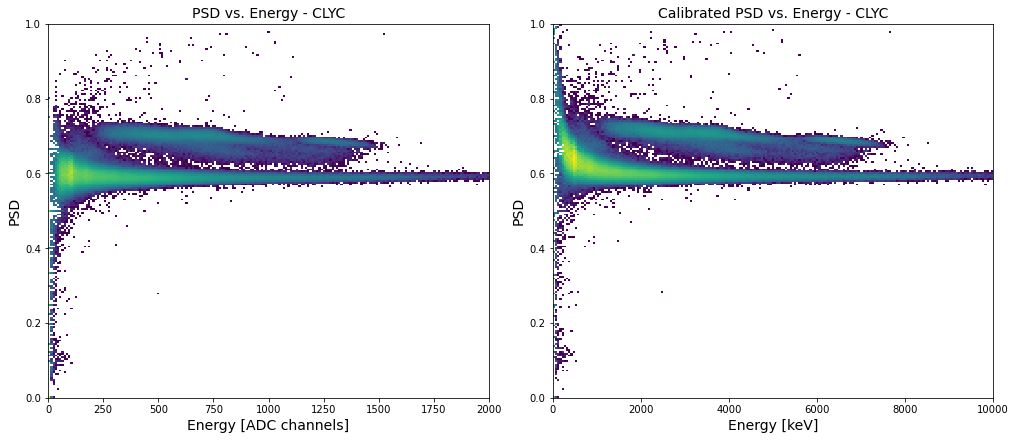

In [10]:
from matplotlib.colors import LogNorm


fig, ax = plt.subplots(1, 2, figsize=(14, 6), constrained_layout=True)

e_bins = np.linspace(0, 2000, 200)
psd_bins = np.linspace(0, 1, 200)

ax[0].hist2d(data_clyc["energy"], data_clyc["psd"], bins=(e_bins, psd_bins), cmap="viridis", norm=LogNorm())
ax[0].set_title("PSD vs. Energy - CLYC", fontsize=14)
ax[0].set_xlabel("Energy [ADC channels]", fontsize=14)
ax[0].set_ylabel("PSD", fontsize=14)

e_bins = np.linspace(0, 10000, 200)
psd_bins = np.linspace(0, 1, 200)

ax[1].hist2d(data_clyc["energy_calib"], data_clyc["psd_calib"], bins=(e_bins, psd_bins), cmap="viridis", norm=LogNorm())
ax[1].set_title("Calibrated PSD vs. Energy - CLYC", fontsize=14)
ax[1].set_xlabel("Energy [keV]", fontsize=14)
ax[1].set_ylabel("PSD", fontsize=14)

plt.show()

## Particle Identification

In [14]:
# assign an id to each point to keep track of it
data_clyc["id"] = np.arange(len(data_clyc))
data_clyc

,board,channel,flag,timestamp,energy,energy_short,energy_calib,energy_short_calib,psd,psd_calib,id
0,1,2,16384,3373955702,184,73,901.837975,339.812658,0.603261,0.623200,0
1,1,2,16384,10480929968,80,32,375.255696,132.217722,0.600000,0.647660,1
2,1,2,16384,13610683468,116,47,557.534177,208.167089,0.594828,0.626629,2
4,1,2,16384,24705541682,649,266,3256.268354,1317.027848,0.590139,0.595541,3
5,1,2,16384,29984914781,42,18,182.850633,61.331646,0.571429,0.664581,4
...,...,...,...,...,...,...,...,...,...,...,...
4022576,1,2,16384,15868456498226562,96,39,456.268354,167.660759,0.593750,0.632539,3223244
4022579,1,2,16384,15868464323128029,104,47,496.774684,208.167089,0.548077,0.580963,3223245
4022580,1,2,16384,15868474285595217,62,26,284.116456,101.837975,0.580645,0.641563,3223246
4022581,1,2,16384,15868474360183998,54,21,243.610127,76.521519,0.611111,0.685885,3223247


In [20]:
# cluster only the points that have PSD > 0.5 and PSD < 0.75 and energy < 2000
df_cluster = data_clyc[(data_clyc["psd"] > 0.5) & (data_clyc["psd"] < 0.75) & (data_clyc["energy"] < 2000)]

df_subset = df_cluster.sample(50000)

df_subset.head()

,board,channel,flag,timestamp,energy,energy_short,energy_calib,energy_short_calib,psd,psd_calib,id
3177404,1,2,16384,12201638019890685,67,25,309.432911,96.774684,0.626866,0.687251,2543456
3644743,1,2,16384,14246530221514452,90,36,425.888608,152.470886,0.600000,0.641994,2919261
2039125,1,2,16384,7357116169903824,778,320,3909.432911,1590.445570,0.588689,0.593177,1628313
1662352,1,2,16384,5877524628090956,672,282,3372.724051,1398.040506,0.580357,0.585486,1326702
584618,1,2,16384,1899935884029406,80,31,375.255696,127.154430,0.612500,0.661153,469820


## Autoencoder

In [21]:
import tensorflow as tf

input_dim  = 2
latent_dim = 16
nlayers    = 5

nmax = 2**nlayers * latent_dim

# encoder
inputs = tf.keras.layers.Input(shape=(input_dim,), name="encoder_input")
encoded = tf.keras.layers.Dense(latent_dim*2**(nlayers+1), activation="relu", name="encoder_layer_1")(inputs)

for l in range(nlayers):
    encoded = tf.keras.layers.Dense(
        latent_dim * 2**(nlayers - (l)),
        activation="relu",
        name=f"encoder_layer_{l + 2}",
    )(encoded)
    encoded = tf.keras.layers.Dropout(0.2)(encoded)

# latent space
latent = tf.keras.layers.Dense(latent_dim, activation="relu", name="latent_space")(encoded)

# decoder
decoded = tf.keras.layers.Dense(latent_dim*2, activation="relu", name="decoder_layer_1")(latent)

for l in range(nlayers):
    decoded = tf.keras.layers.Dense(
        latent_dim * 2**(l+2),
        activation="relu",
        name=f"decoder_layer_{l + 2}",
    )(decoded)
    decoded = tf.keras.layers.Dropout(0.2)(decoded)

outputs = tf.keras.layers.Dense(input_dim, activation="relu", name="decoder_output")(decoded)

# autoencoder
autoencoder = tf.keras.Model(inputs, outputs, name="autoencoder")

autoencoder.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5), loss=tf.keras.losses.MeanSquaredError())

autoencoder.summary()

Model: "autoencoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_input (InputLayer)  [(None, 2)]               0         
                                                                 
 encoder_layer_1 (Dense)     (None, 1024)              3072      
                                                                 
 encoder_layer_2 (Dense)     (None, 512)               524800    
                                                                 
 dropout_10 (Dropout)        (None, 512)               0         
                                                                 
 encoder_layer_3 (Dense)     (None, 256)               131328    
                                                                 
 dropout_11 (Dropout)        (None, 256)               0         
                                                                 
 encoder_layer_4 (Dense)     (None, 128)               

In [22]:
# Create the autoencoder model
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X = scaler.fit_transform(df_subset[['energy', 'psd']])

# Fit the model to the data
autoencoder.fit(X, X, epochs=10, batch_size=50, shuffle=True, validation_split=0.2)


Epoch 1/10


2022-12-25 17:54:16.139129: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


799/800 [============================>.] - ETA: 0s - loss: 0.7276

2022-12-25 17:54:30.330971: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


800/800 [==============================] - 16s 18ms/step - loss: 0.7275 - val_loss: 0.5904
Epoch 2/10
800/800 [==============================] - 14s 18ms/step - loss: 0.5235 - val_loss: 0.3293
Epoch 3/10
800/800 [==============================] - 14s 18ms/step - loss: 0.2751 - val_loss: 0.2555
Epoch 4/10
800/800 [==============================] - 14s 18ms/step - loss: 0.2428 - val_loss: 0.2547
Epoch 5/10
800/800 [==============================] - 14s 18ms/step - loss: 0.2392 - val_loss: 0.2554
Epoch 6/10
800/800 [==============================] - 14s 18ms/step - loss: 0.2382 - val_loss: 0.2551
Epoch 7/10
800/800 [==============================] - 14s 18ms/step - loss: 0.2378 - val_loss: 0.2541
Epoch 8/10
800/800 [==============================] - 14s 18ms/step - loss: 0.2376 - val_loss: 0.2553
Epoch 9/10
800/800 [==============================] - 14s 18ms/step - loss: 0.2374 - val_loss: 0.2549
Epoch 10/10
800/800 [==============================] - 14s 18ms/step - loss: 0.2373 - val_los

2022-12-25 17:56:40.370166: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-25 17:56:44.005481: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


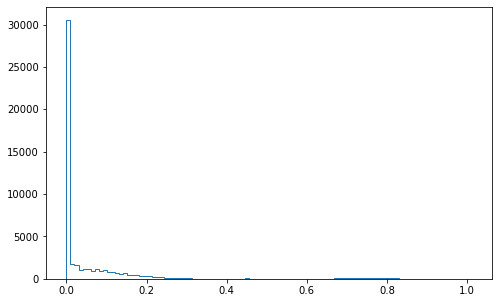

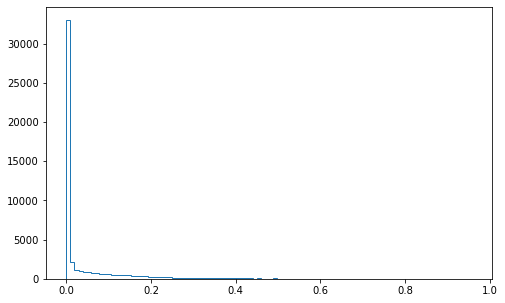

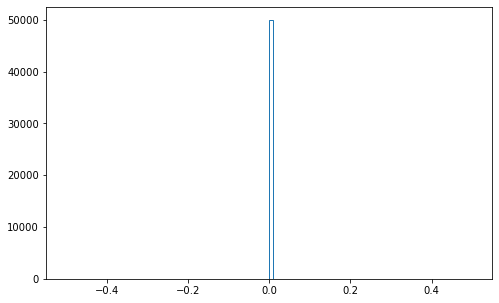

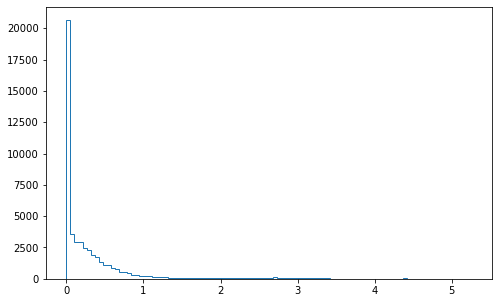

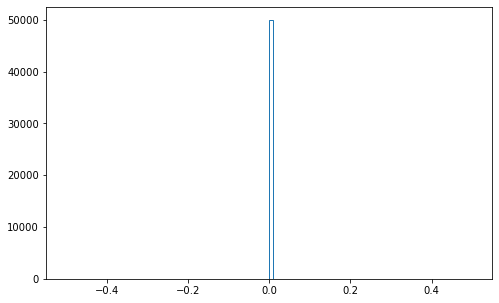

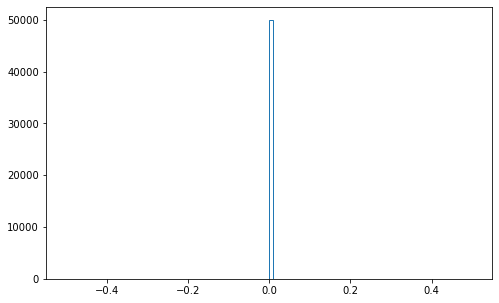

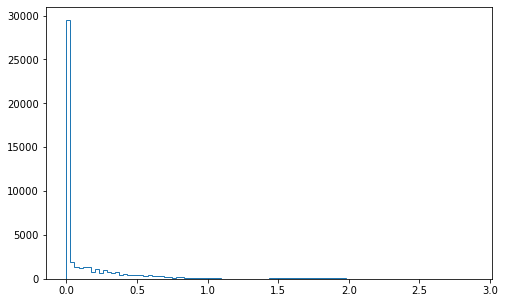

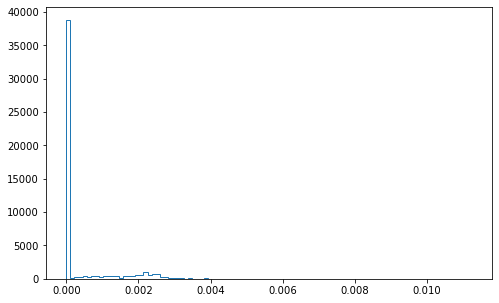

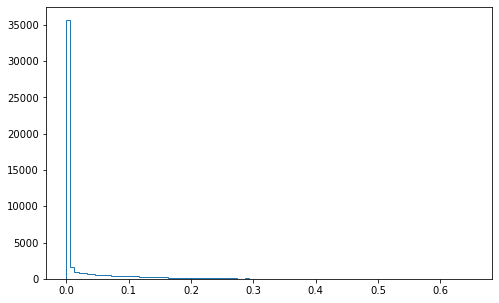

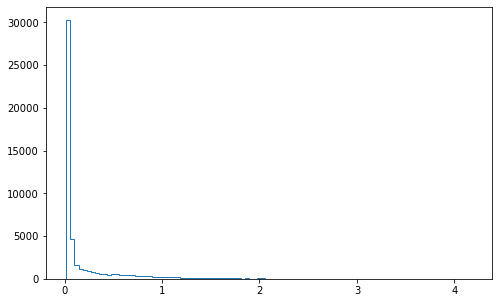

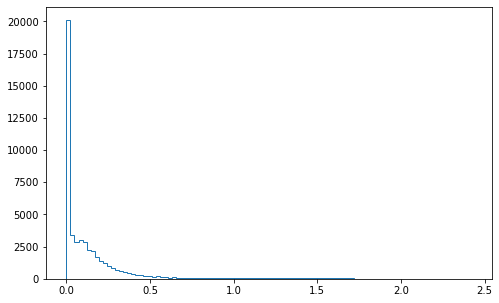

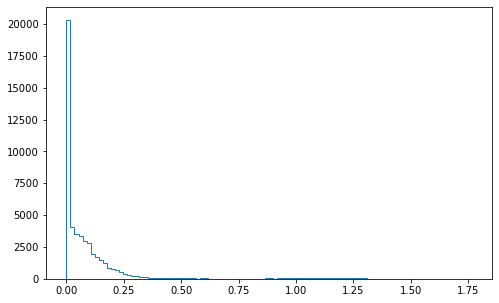

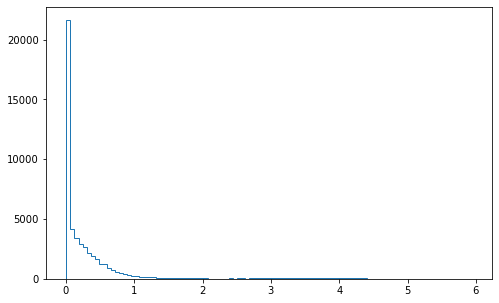

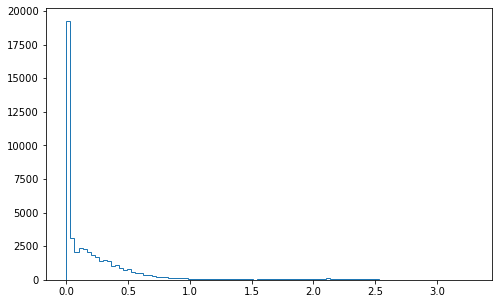

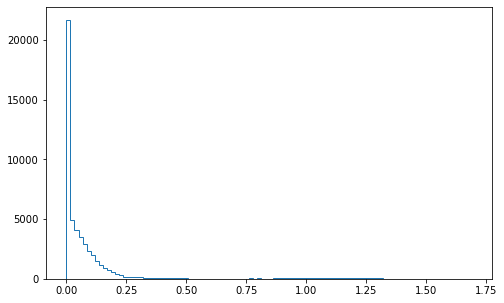

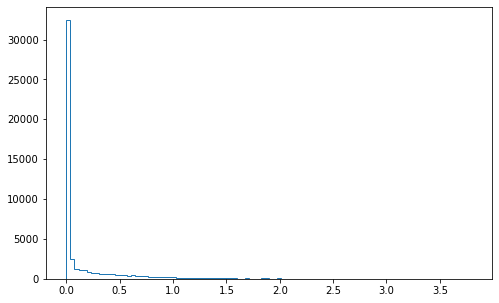

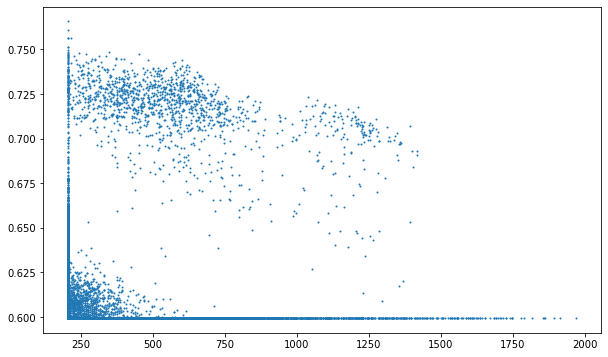

In [23]:
encoder     = tf.keras.Model(inputs, latent)
decoder     = tf.keras.Model(latent, outputs)

# Encode the input data to the latent space
latent_space = encoder.predict(X)

# Decode the latent space back to the original input space
reconstructed_input = decoder.predict(latent_space)

# visualize the latent space

for f in range(latent_space.shape[1]):
    fig, ax = plt.subplots(1, 1, figsize=(8, 5))
    ax.hist(latent_space[:, f], bins=100, histtype="step", label=f"Feature {f}")
    plt.show()

X_reversed = scaler.inverse_transform(reconstructed_input)
# visualize the reconstructed input space
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
ax.scatter(X_reversed[:, 0], X_reversed[:, 1], s=1, label="Reconstructed input")
plt.show()

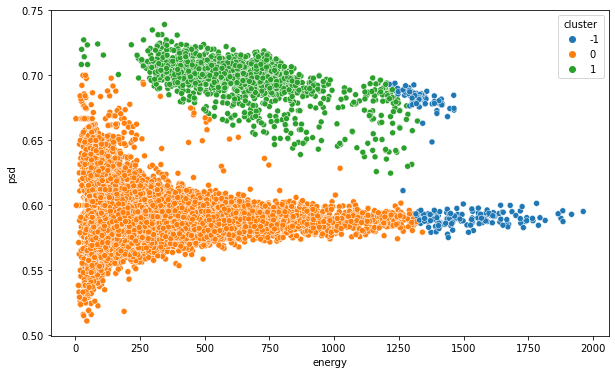

In [24]:
# use DBSCAN to find clusters

dbscan = DBSCAN(eps=1.4, min_samples=600)
cluster_labels = dbscan.fit_predict(latent_space)

df_subset['cluster'] = cluster_labels

# visualize the clusters
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

sns.scatterplot(data=df_subset, x="energy", y="psd", hue="cluster", ax=ax, palette="tab10")

# ax.set_xscale("log")
plt.show()

In [51]:
df_subset['cluster'] = cluster_labels

In [54]:
# if the row with cluster label 1 has energy < 250 then its label is 0
df_subset.loc[(df_subset["cluster"] == 1) & (df_subset["energy"] < 200), "cluster"] = 0

# if the row with cluster label -1 has pdf greater than 0.65 then its label is 1
df_subset.loc[(df_subset["cluster"] == -1) & (df_subset["psd"] > 0.65) & (df_subset["energy"] > 220), "cluster"] = 1

# set all noise points to be label 0
df_subset.loc[df_subset["cluster"] == -1, "cluster"] = 0

# if the row with cluster label 0 has psd > 0.62 and energy > 200 then its label is 1
df_subset.loc[(df_subset["cluster"] == 0) & (df_subset["psd"] > 0.62) & (df_subset["energy"] > 500), "cluster"] = 1

# if the row has energy between 200 and 500 and psd > 0.65 then its label is 1
df_subset.loc[(df_subset["cluster"] == 0) & (df_subset["energy"] > 260) & (df_subset["energy"] < 500) & (df_subset["psd"] > 0.65), "cluster"] = 1

# if the row has energy between 400 and 500 and psd between 0.64 and 0.66 then its label is 1
df_subset.loc[(df_subset["cluster"] == 0) & (df_subset["energy"] > 400) & (df_subset["energy"] < 500) & (df_subset["psd"] > 0.64) & (df_subset["psd"] < 0.66), "cluster"] = 1

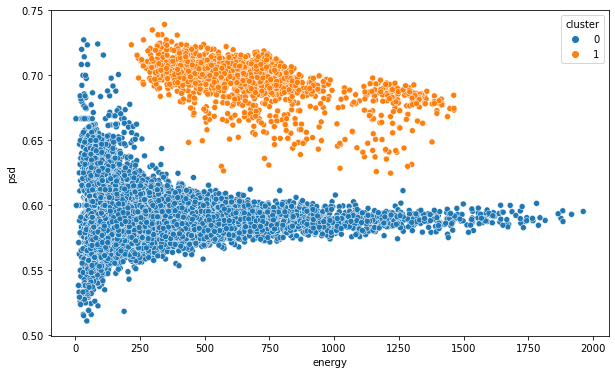

In [55]:
# visualize the clusters
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

sns.scatterplot(data=df_subset, x="energy", y="psd", hue="cluster", ax=ax, palette="tab10")

# ax.set_xscale("log")
plt.show()

## Classifier

In [56]:
# build a classifier to distinguish between the two clusters and train it on the subset of the data

inputs = tf.keras.layers.Input(shape=(input_dim,), name="classifier_input")
dense = tf.keras.layers.Dense(32, activation="relu", name="classifier_layer_1")(inputs)
dense = tf.keras.layers.Dense(32, activation="relu", name="classifier_layer_2")(dense)
dense = tf.keras.layers.Dense(32, activation="relu", name="classifier_layer_3")(dense)
dense = tf.keras.layers.Dense(32, activation="relu", name="classifier_layer_4")(dense)
outputs = tf.keras.layers.Dense(1, activation="sigmoid", name="classifier_output")(dense)

model = tf.keras.Model(inputs, outputs, name="classifier")

model.compile(optimizer=tf.keras.optimizers.Adam(), loss=tf.keras.losses.BinaryCrossentropy(), metrics=["accuracy"])

model.summary()

Model: "classifier"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 classifier_input (InputLaye  [(None, 2)]              0         
 r)                                                              
                                                                 
 classifier_layer_1 (Dense)  (None, 32)                96        
                                                                 
 classifier_layer_2 (Dense)  (None, 32)                1056      
                                                                 
 classifier_layer_3 (Dense)  (None, 32)                1056      
                                                                 
 classifier_layer_4 (Dense)  (None, 32)                1056      
                                                                 
 classifier_output (Dense)   (None, 1)                 33        
                                                        

In [58]:
# save df_subset to a csv file as training set day 3
df_subset.to_csv("./data/training_set_day3.csv", index=False)

In [57]:
# scale the data
X = scaler.fit_transform(df_subset[['energy', 'psd']])
Y = df_subset['cluster']

# train the model
model.fit(X, Y, epochs=10, batch_size=50, shuffle=True, validation_split=0.2)

Epoch 1/10


2022-12-25 18:03:31.873007: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


796/800 [============================>.] - ETA: 0s - loss: 0.0331 - accuracy: 0.9965

2022-12-25 18:03:39.986930: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


800/800 [==============================] - 9s 10ms/step - loss: 0.0329 - accuracy: 0.9965 - val_loss: 3.2252e-04 - val_accuracy: 0.9999
Epoch 2/10
800/800 [==============================] - 8s 10ms/step - loss: 3.7964e-04 - accuracy: 1.0000 - val_loss: 3.5992e-04 - val_accuracy: 0.9998
Epoch 3/10
800/800 [==============================] - 8s 10ms/step - loss: 5.2951e-05 - accuracy: 1.0000 - val_loss: 1.2171e-04 - val_accuracy: 0.9999
Epoch 4/10
800/800 [==============================] - 8s 10ms/step - loss: 2.5587e-05 - accuracy: 1.0000 - val_loss: 9.1888e-04 - val_accuracy: 0.9997
Epoch 5/10
800/800 [==============================] - 8s 10ms/step - loss: 0.0011 - accuracy: 0.9998 - val_loss: 1.4595e-04 - val_accuracy: 0.9999
Epoch 6/10
800/800 [==============================] - 8s 10ms/step - loss: 2.1097e-05 - accuracy: 1.0000 - val_loss: 1.5594e-04 - val_accuracy: 0.9999
Epoch 7/10
800/800 [==============================] - 8s 10ms/step - loss: 1.2502e-05 - accuracy: 1.0000 - val_lo

In [62]:
# test_data = df_cluster.sample(50000)

pred = model.predict(scaler.transform(df_cluster[['energy', 'psd']]))

In [63]:
# turn predictions into either 0 or 1 depending on the threshold value of 0.5
pred_int = np.where(pred > 0.5, 1, 0)

In [64]:
df_cluster["cluster"] = pred_int

df_cluster.to_csv("./data/data_clyc_with_cluster_day3.csv", index=False)

/var/folders/q3/r96zncz17lq5z2jf1vj44c700000gn/T/ipykernel_8932/2319872713.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cluster["cluster"] = pred_int


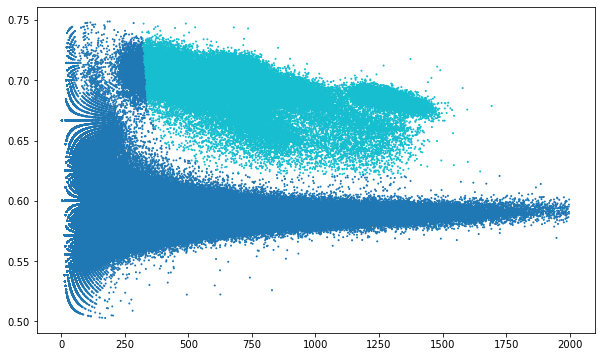

In [65]:
# visualize the predictions
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

ax.scatter(df_cluster['energy'], df_cluster['psd'], c=pred_int, s=1, cmap="tab10")

plt.show()